In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio as rio
from glob import glob
import os, sys
import itertools
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# get y variable names
y_var_dir = '../../../data/y_tiles/'
y_files = glob(y_var_dir + "/*.tif")
y_vars = set([os.path.basename(f).split('_')[0] for f in y_files])
y_vars

{'Arson',
 'Campfire',
 'Children',
 'DebrisBurning',
 'EquipmentUse',
 'Fireworks',
 'Human',
 'Lightning',
 'Miscellaneous',
 'Powerline',
 'Railroad',
 'Smoking',
 'Structure'}

150

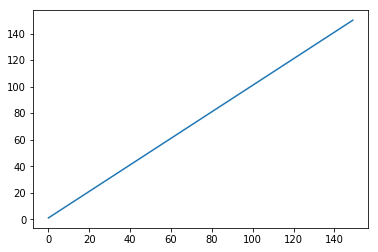

In [9]:
tiles = set([os.path.basename(f).split('_')[-1].split('.')[0] for f in y_files])
tiles
tilenum = [int(t.split('t')[-1]) for t in tiles]
plt.plot(sorted(tilenum))
min(tilenum), max(tilenum)
max(list(range(1, 151)))

In [3]:
# get x variable names
x_var_dir = '../../../data/x_tiles/'
x_files = glob(x_var_dir + "/*.tif")
x_vars = set([os.path.basename(f).split('_')[0] for f in x_files])
x_vars

{'aet-95th', 'aet-mean'}

In [26]:
class yDatasetSingleVar(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, transform=None, ig_type='Arson'):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include 
        """
        assert os.path.exists(data_dir)
        
        self.data_dir = data_dir
        self.transform = transform
        self.ig_types = ig_type # should have a default...
        self.val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
        self.tile_nums = set([os.path.basename(f).split('_')[-1].split('.tif')[0] for f in y_files])
        self.files = glob(data_dir + "/*{}*.tif".format(ig_type))
        self.month_tile = itertools.product(self.val_months, self.tile_nums)
        self.fi = None
        
        ## could also set up a set of variable names if specifying it in the constructor proves difficult
        #y_vars = set([os.path.basename(f).split('_')[0] for f in y_files])
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <ig_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        fi = self.files[idx] 
        print(fi)
        valid_thresh = -100000
        with rio.open(fi) as src:
            img_arr = src.read(1)
            img_arr[img_arr<0] = 0
            
            ## any thing matching this condition for X vars replace with mean of valid vals
            img_arr[img_arr <= -2.4e+38] = img_arr[img_arr > valid_thresh].mean()
        
        print(img_arr.shape)
        
        if self.transform is not None:
            return self.transform(torch.from_numpy(img_arr))   
        else:
            return torch.from_numpy(img_arr)
        
        
    def __len__(self):
        return len(self.files)

In [27]:
test_single_var = yDatasetSingleVar(y_var_dir, ig_type='Campfire') # variable is Arson by default

In [28]:
for var in y_vars:
    test_dl = yDatasetSingleVar(y_var_dir, ig_type=var)
    print('{}: {}'.format(var, len(test_dl)))

Campfire: 43201
Human: 43200
Lightning: 43200
Railroad: 43200
Arson: 43200
Miscellaneous: 43200
Smoking: 43200
Structure: 43200
Powerline: 43200
Children: 43203
EquipmentUse: 43201
DebrisBurning: 43200
Fireworks: 43200


In [29]:
## looks like most y-vars have 43200 files, but Children, Campfire, and Equipment have more.
## try to find out the filenames which are not like the other variables!
equipment = glob(y_var_dir + "/{}*.tif".format('Equipment'))
children = glob(y_var_dir + "/{}*.tif".format('Children'))
campfire = glob(y_var_dir + "/{}*.tif".format('Campfire'))
base = glob(y_var_dir + "/{}*.tif".format('Arson'))

print(equipment[0])
print(children[0])
print(campfire[0])
print(base[0])

../../../data/y_tiles\EquipmentUse_1992_10_t1.tif
../../../data/y_tiles\Children_1992_10_t1.tif
../../../data/y_tiles\Campfire_1992_10_t1.tif
../../../data/y_tiles\Arson_1992_10_t1.tif


In [30]:
# get just the year_month_tile.tif
equip = ['_'.join(f.split('_')[-3:]) for f in equipment]
child = ['_'.join(f.split('_')[-3:]) for f in children]
camp = ['_'.join(f.split('_')[-3:]) for f in campfire]
b = ['_'.join(f.split('_')[-3:]) for f in base]

In [31]:
print('equipment use difference')
print(np.setdiff1d(equip, b))

print('\nchildren difference')
print(np.setdiff1d(child, b))

print('\ncampfire difference')
print(np.setdiff1d(camp, b))

equipment use difference
['tiles\\EquipmentUse_2013_t82.tif']

children difference
['tiles\\Children_2008_t4.tif' 'tiles\\Children_2008_t8.tif'
 'tiles\\Children_2013_t1.tif']

campfire difference
['tiles\\Campfire_2013_t87.tif']


In [32]:
temp_list = []
for ig_type in ['Arson', 'Campfire']:
    files = glob(y_var_dir + "/{}*.tif".format(ig_type))
    print('{}: {}'.format(ig_type, len(files)))
    temp_list.append(files)
    
print(len(temp_list))

Arson: 43200
Campfire: 43201
2


In [22]:
class yDatasetMultiVar(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, transform=None, ig_types=['Arson', 'Campfire']):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include 
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        assert len(ig_types) > 1
        val_ig_types = set([os.path.basename(f).split('_')[0] for f in glob(data_dir + '/*.tif')])
        for v in val_ig_types:
            assert v in list(val_ig_types)
        
        # initialize some attributes
        self.data_dir = data_dir
        self.transform = transform
        self.ig_types = ig_types # should have a default...
        self.val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
        
        # the filenaming is not consistent to get the years from the filename :(
        #self.val_years = set([os.path.basename(f).split('_')[-3] for f in y_files if (len(os.path.basename(f).split('_')) > 3)])
        self.val_years = list(range(1992,2016)) # 2015, since it is open-ended on the right
        
        self.tile_nums = set([os.path.basename(f).split('_')[-1].split('.tif')[0] for f in y_files])
        
        # get the files for ig_type[0]... need to assert that num_files for each ig_type is equal
        self.files = glob(data_dir + "/*{}*.tif".format(ig_types[0]))
        temp_list = []
        for ig_type in ig_types:
            files = glob(data_dir + "/{}*.tif".format(ig_type))
            temp_list.append(files)
        
        # this should ensure that the file numbers are equal
        for flist in temp_list[1:]:
            assert len(temp_list[0]) == len(flist)        
        
        # create an iterable for the __getitem__ method
        self.var_year_month_tile = list(itertools.product(self.ig_types, self.val_years, self.val_months, self.tile_nums))
        self.year_month_tile = list(itertools.product(self.val_years, self.val_months, self.tile_nums))
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <ig_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        #var, year, month, tile = self.var_year_month_tile[idx]
        year, month, tile = self.year_month_tile[idx]
        files = [os.path.join(self.data_dir, '{}_{}_{}_{}.tif'.format(var, year, month, tile)) for var in self.ig_types]
        arrs = []
        
        print(files)
        
        valid_thresh = -100000
        for fi in files:
            with rio.open(fi) as src:
                arr = src.read(1)
                
                ## any thing matching this condition for X vars replace with mean of valid vals
                # valid Y nodata should be replaced with zeros
                #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
                arr[arr <= -2.4e+38] = 0
            
            arrs.append(arr)
        img_arr = np.array(arrs)
        
        if self.transform is not None:
            return self.transform(torch.from_numpy(img_arr))   
        else:
            return torch.from_numpy(img_arr) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.files)

In [23]:
# Campfire: 43201
# Children: 43203
# Railroad: 43200
# EquipmentUse: 43201
# Powerline: 43200
# Smoking: 43200
# Fireworks: 43200
# Human: 43200
# Miscellaneous: 43200
# Structure: 43200
# Lightning: 43200
# DebrisBurning: 43200
# Arson: 43200

test_multi_var = yDatasetMultiVar(y_var_dir, ig_types=['Arson', 'Railroad', 'Powerline']) # variable is Arson by default


43200
43200


In [24]:
test_multi_var[0].shape

['../../../data/y_tiles/Arson_1992_1_t88.tif', '../../../data/y_tiles/Railroad_1992_1_t88.tif', '../../../data/y_tiles/Powerline_1992_1_t88.tif']


C:\software\Anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice.
C:\software\Anaconda3\envs\eapy_gbdx\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


torch.Size([3, 448, 448])

In [49]:
class xymDatasetMultiVar(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, y_data_dir, x_data_dir, land_mask_dir, y_transform=None, x_transform=None, ig_types=['Arson', 'Campfire'], x_var=['aet-95th']):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(y_data_dir)
        assert os.path.exists(x_data_dir)
        assert os.path.exists(land_mask_dir)
        assert len(ig_types) > 1
        assert len(x_var) > 1
        
        val_ig_types = set([os.path.basename(f).split('_')[0] for f in glob(y_data_dir + '/*.tif')])
        for v in ig_types:
            assert v in list(val_ig_types)
            
        val_x_var = set([os.path.basename(f).split('_')[0] for f in glob(x_data_dir + '/*.tif')])
        for v in x_var:
            assert v in list(val_x_var)
        
        # initialize some attributes
        self.y_data_dir = y_data_dir
        self.x_data_dir = x_data_dir
        self.land_mask_dir = land_mask_dir
        
        self.x_transform = x_transform
        self.y_transform = y_transform
        self.ig_types = ig_types # should have a default...
        self.x_var = x_var
        self.val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
        
        # the filenaming is not consistent to get the years from the filename :(
        #self.val_years = set([os.path.basename(f).split('_')[-3] for f in y_files if (len(os.path.basename(f).split('_')) > 3)])
        self.val_years = list(range(1992,2016)) # 2015, since it is open-ended on the right
        
        ## y variable assertion
        # get the files for ig_type[0]... need to assert that num_files for each ig_type is equal
        self.files = glob(y_data_dir + "/*{}*.tif".format(ig_types[0]))
        temp_list = []
        for ig_type in ig_types:
            files = glob(y_data_dir + "/{}*.tif".format(ig_type))
            temp_list.append(files)
        
        # this should ensure that the file numbers are equal
        for flist in temp_list[1:]:
            assert len(temp_list[0]) == len(flist)       
            
            
        ## x variable assertion
        
        # get the tile numbers
        self.tile_nums = set([os.path.basename(f).split('_')[-1].split('.tif')[0] for f in files])
        
        # create an iterable for the __getitem__ method
        self.year_month_tile = list(itertools.product(self.val_years, self.val_months, self.tile_nums))
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        #var, year, month, tile = self.var_year_month_tile[idx]
        year, month, tile = self.year_month_tile[idx]
        y_files = [os.path.join(self.y_data_dir, '{}_{}_{}_{}.tif'.format(var, year, month, tile)) for var in self.ig_types]
        x_files = [os.path.join(self.x_data_dir, '{}_{}_{}_{}.tif'.format(var, year, month, tile)) for var in self.x_var]
        land_mask_file = os.path.join(self.x_data_dir, '{}_{}_{}_{}.tif'.format('land-mask', year, month, tile))
        
        # load y_files
        arrs = []
        valid_thresh = -100000
        for fi in y_files:
            with rio.open(fi) as src:
                arr = src.read(1)
                
                ## any thing matching this condition for X vars replace with mean of valid vals
                # valid Y nodata should be replaced with zeros
                #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
                arr[arr <= -2.4e+38] = 0
            
            arrs.append(arr)
        y_arr = np.array(arrs)
        
        # load x_files
        arrs = []
        valid_thresh = -100000
        for fi in x_files:
            with rio.open(fi) as src:
                arr = src.read(1)
                
                ## any thing matching this condition for X vars replace with mean of valid vals
                # valid Y nodata should be replaced with zeros
                #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
                arr[arr <= -2.4e+38] = 0
            
            arrs.append(arr)
        x_arr = np.array(arrs)
        
        # load land_mask
        valid_thresh = -100000
        with rio.open(fi) as src:
            land_mask_arr = src.read()

            ## any thing matching this condition for X vars replace with mean of valid vals
            # valid Y nodata should be replaced with zeros
            #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
            arr[arr <= -2.4e+38] = 0

        
        
        if (self.y_transform is not None) and (self.x_transform is not None):
            return (self.y_transform(torch.from_numpy(y_arr)), 
                    self.x_transform(torch.from_numpy(x_arr)), 
                    torch.from_numpy(land_mask_arr))   
        else:
            return (torch.from_numpy(y_arr), torch.from_numpy(x_arr), torch.from_numpy(land_mask_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.files)

In [50]:
y_var_dir = '../../../data/y_tiles/'
x_var_dir = '../../../data/x_tiles/'
land_mask_dir = '../../../data/land_mask/'
test_xym = xymDatasetMultiVar(y_var_dir, x_var_dir, land_mask_dir, y_transform=None, x_transform=None, ig_types=['Arson', 'Railroad', 'Powerline'], x_var=['aet-95th', 'aet-mean'])
        

In [51]:
y, x, m = test_xym[0]

In [52]:
y.shape, x.shape, m.shape

(torch.Size([3, 448, 448]),
 torch.Size([2, 448, 448]),
 torch.Size([1, 448, 448]))

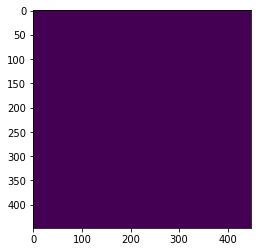

In [55]:
from matplotlib import pyplot as plt

plt.imshow(m[0])

## try to get the data directly from S3

In [4]:
class xymDatasetMultiVar_S3(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, y_data_dir, x_data_dir, land_mask_dir, y_transform=None, x_transform=None, ig_types=['Arson', 'Campfire'], x_var=['aet-95th']):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks... equivalent on S3?
        #assert os.path.exists(y_data_dir)
        #assert os.path.exists(x_data_dir)
        #assert os.path.exists(land_mask_dir)
        assert len(ig_types) > 1
        assert len(x_var) > 1
        
        # can't to these in S3 either... need a dictionary maybe?
        #val_ig_types = set([os.path.basename(f).split('_')[0] for f in glob(y_data_dir + '/*.tif')])
        #for v in ig_types:
        #    assert v in list(val_ig_types)
            
        #val_x_var = set([os.path.basename(f).split('_')[0] for f in glob(x_data_dir + '/*.tif')])
        #for v in x_var:
        #    assert v in list(val_x_var)
        
        # initialize some attributes
        self.y_data_dir = y_data_dir
        self.x_data_dir = x_data_dir
        self.land_mask_dir = land_mask_dir
        
        self.x_transform = x_transform
        self.y_transform = y_transform
        self.ig_types = ig_types 
        self.x_var = x_var
        #self.val_months = set([os.path.basename(f).split('_')[-2] for f in y_files if int(os.path.basename(f).split('_')[-2]) <=12])
        self.val_months = [str(i+1) for i in range(12)]
        
        # the filenaming is not consistent to get the years from the filename :(
        self.val_years = list(range(1992,2016)) # 2015, since it is open-ended on the right
        
        ## y variable assertion... can't do in S3
        # get the files for ig_type[0]... need to assert that num_files for each ig_type is equal
        #self.files = glob(y_data_dir + "/*{}*.tif".format(ig_types[0]))
        #temp_list = []
        #for ig_type in ig_types:
        #    files = glob(y_data_dir + "/{}*.tif".format(ig_type))
        #    temp_list.append(files)
        
        # this should ensure that the file numbers are equal
        #for flist in temp_list[1:]:
        #    assert len(temp_list[0]) == len(flist)       
            
            
        ## x variable assertion...same, can't do in S3
        
        # get the tile numbers
        self.tile_nums = list(range(1, 151)) # min is 1, max is 150 
        
        # create an iterable for the __getitem__ method
        self.year_month_tile = list(itertools.product(self.val_years, self.val_months, self.tile_nums))
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        #var, year, month, tile = self.var_year_month_tile[idx]
        year, month, tile = self.year_month_tile[idx]
        y_files = [self.y_data_dir + '/{}_{}_{}_t{}.tif'.format(var, year, month, tile) for var in self.ig_types]
        x_files = [self.x_data_dir + '/{}_{}_{}_t{}.tif'.format(var, year, month, tile) for var in self.x_var]
        land_mask_file = self.x_data_dir +  '/{}_{}_{}_t{}.tif'.format('land-mask', year, month, tile)
        
        ## some additional considerations for climate variables which contain mean and 95th percentile
        #clim_mean_files = [self.x_data_dir + '/{}_{}_mean_{}_{}.tif'.format(var, year, month, tile) for var in self.x_var]
        #clim_95_files = [self.x_data_dir + '/{}_{}_95th_{}_{}.tif'.format(var, year, month, tile) for var in self.x_var]
        
        print(y_files)
        # load y_files
        arrs = []
        valid_thresh = -100000
        for fi in y_files:
            with rio.open(fi) as src:
                arr = src.read(1)
                
                ## any thing matching this condition for X vars replace with mean of valid vals
                # valid Y nodata should be replaced with zeros
                #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
                arr[arr <= -2.4e+38] = 0
            
            arrs.append(arr)
        y_arr = np.array(arrs)
        
        # load x_files
        arrs = []
        valid_thresh = -100000
        for fi in x_files:
            with rio.open(fi) as src:
                arr = src.read(1)
                
                ## any thing matching this condition for X vars replace with mean of valid vals
                # valid Y nodata should be replaced with zeros
                #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
                arr[arr <= -2.4e+38] = 0
            
            arrs.append(arr)
        x_arr = np.array(arrs)
        
        # load land_mask
        valid_thresh = -100000
        with rio.open(fi) as src:
            land_mask_arr = src.read()

            ## any thing matching this condition for X vars replace with mean of valid vals
            # valid Y nodata should be replaced with zeros
            #arr[arr <= -2.4e+38] = arr[arr > valid_thresh].mean()
            arr[arr <= -2.4e+38] = 0

        
        
        if (self.y_transform is not None) and (self.x_transform is not None):
            return (self.y_transform(torch.from_numpy(y_arr)), 
                    self.x_transform(torch.from_numpy(x_arr)), 
                    torch.from_numpy(land_mask_arr))   
        else:
            return (torch.from_numpy(y_arr), torch.from_numpy(x_arr), torch.from_numpy(land_mask_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.files)

In [5]:
s3_y = 's3://earthlab-modeling-human-ignitions/tiles/y_var'
s3_x = 's3://earthlab-modeling-human-ignitions/tiles/x_var'
s3_lm = 's3://earthlab-modeling-human-ignitions/tiles/x_var'
test_xym_s3 = xymDatasetMultiVar_S3(s3_y, s3_x, s3_lm, y_transform=None, x_transform=None, ig_types=['Arson', 'Railroad', 'Powerline'], x_var=['elevation', 'aspect'])

In [8]:
y3, x3, lm3 = test_xym_s3[1]

['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t2.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t2.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t2.tif']


In [26]:
-339999995214436424907732413799364296704. < -2.4e+38

True

In [9]:
y3.shape

torch.Size([3, 320, 448])

In [10]:
x3.shape

torch.Size([2, 320, 448])

In [11]:
lm3.shape

torch.Size([1, 320, 448])

In [14]:
from time import time
time()

1550608296.3141701

In [15]:
t0 = time()
y3, x3, lm3 = test_xym_s3[1]
t1 = time()

print('time is {} seconds'.format(t1-t0))

['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t2.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t2.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t2.tif']
time is 6.511555194854736 seconds


In [18]:
times = []
for i in range(100):
    t0 = time()
    y3, x3, lm3 = test_xym_s3[i]
    t1 = time()

    print('{}: time is {} seconds'.format(i+1, t1-t0))
    times.append(t1-t0)

['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t1.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t1.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t1.tif']
1: time is 6.56514573097229 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t2.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t2.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t2.tif']
2: time is 6.536616563796997 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t3.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t3.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t3.tif']
3: time is 6.5851006507873535 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t4.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t4.tif', 's3://earthlab-modeling-human-ignitions/tiles/y

31: time is 6.911356687545776 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t32.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t32.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t32.tif']
32: time is 6.803026914596558 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t33.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t33.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t33.tif']
33: time is 6.756707429885864 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t34.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t34.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t34.tif']
34: time is 6.79748010635376 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t35.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t35.ti

62: time is 6.841642618179321 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t63.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t63.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t63.tif']
63: time is 6.809499263763428 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t64.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t64.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t64.tif']
64: time is 6.985856771469116 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t65.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t65.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t65.tif']
65: time is 7.104281902313232 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t66.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t66.t

93: time is 7.473527908325195 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t94.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t94.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t94.tif']
94: time is 7.312894105911255 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t95.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t95.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t95.tif']
95: time is 7.315048694610596 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t96.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t96.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Powerline_1992_1_t96.tif']
96: time is 7.42643141746521 seconds
['s3://earthlab-modeling-human-ignitions/tiles/y_var/Arson_1992_1_t97.tif', 's3://earthlab-modeling-human-ignitions/tiles/y_var/Railroad_1992_1_t97.ti

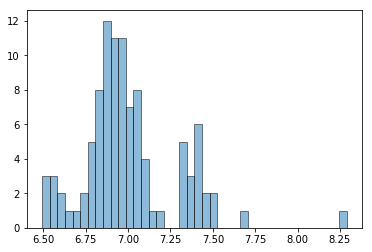

In [22]:
plt.hist(times, bins=40, edgecolor='k', alpha=0.5);